# Data cleaning

In [85]:
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
np.random.seed(18422761)

Imputing missing values

In [2]:
data = read_csv('musicData.csv', delimiter=',').to_numpy()

In [3]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputed_data = imputer.fit_transform(data)

In [4]:
imputer = SimpleImputer(missing_values='?', strategy='most_frequent')
imputed_data = imputer.fit_transform(imputed_data)

In [5]:
imputed_data[:,6]

array([-1.0, 218293.0, 215613.0, ..., 189483.0, 262773.0, 267267.0],
      dtype=object)

In [6]:
imputer = SimpleImputer(missing_values=-1.0, strategy='median')
imputed_data[:,6] = imputer.fit_transform(imputed_data[:,6].reshape(-1, 1)).reshape(50005, )

One-hot encoding

In [7]:
enc = OneHotEncoder(drop='first', sparse_output=False)
enc.fit(imputed_data[:,9].reshape(-1, 1))
enc.categories_

[array(['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'],
       dtype=object)]

In [8]:
encoded = enc.transform(imputed_data[:,9].reshape(-1, 1))
onehot_data = np.append(imputed_data[:,:9], encoded, axis = 1)
onehot_data = np.append(onehot_data, imputed_data[:,10:], axis = 1)

In [9]:
enc.fit(onehot_data[:,-1:].reshape(-1, 1))
enc.categories_

[array(['Alternative', 'Anime', 'Blues', 'Classical', 'Country',
        'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock'], dtype=object)]

In [10]:
encoded = enc.transform(onehot_data[:,-1:].reshape(-1, 1))
onehot_data = np.append(onehot_data[:,:27], encoded, axis = 1)

In [11]:
enc.fit(onehot_data[:,22].reshape(-1, 1))
enc.categories_

[array(['Major', 'Minor'], dtype=object)]

In [12]:
encoded = enc.transform(onehot_data[:,22].reshape(-1, 1))
temp = onehot_data[:,23:]
onehot_data = np.append(onehot_data[:,:22], encoded, axis = 1)
onehot_data = np.append(onehot_data, temp, axis = 1)

Removing irrelevant/hard to use data

In [13]:
useful_data = np.delete(onehot_data, [0,1,2,25], axis=1)

Standardizing non-categorical columns

In [14]:
scaler = StandardScaler()
zscored_data = useful_data
zscored_data[:,[0,1,2,3,4,5,17,18,20,21,22]] = scaler.fit_transform(useful_data[:,[0,1,2,3,4,5,17,18,20,21,22]])

In [15]:
X = zscored_data[:,:-9]
y = zscored_data[:,-9:]

# Dimension Reduction

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, imputed_data[:,17])

LinearDiscriminantAnalysis()

Text(0, 0.5, 'Explained variance ratio')

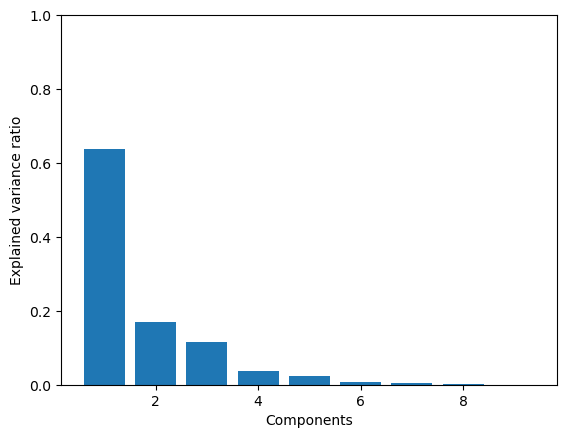

In [17]:
plt.bar([1,2,3,4,5,6,7,8,9], lda.explained_variance_ratio_)
plt.ylim(0, 1)
plt.xlabel("Components")
plt.ylabel("Explained variance ratio")

In [18]:
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X, imputed_data[:,17])
X_lda = lda.transform(X)

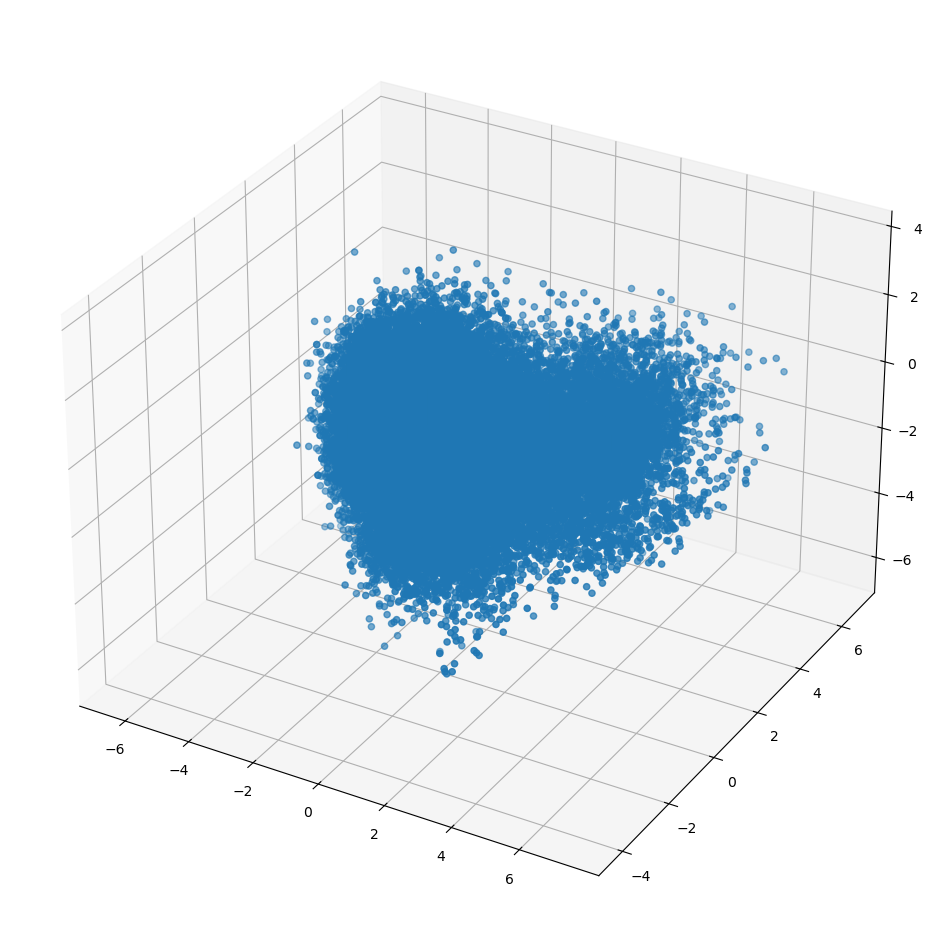

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_lda[:,0], X_lda[:,1], X_lda[:,2])
plt.show()

# Clustering

Text(0, 0.5, 'Silhouette coefficient')

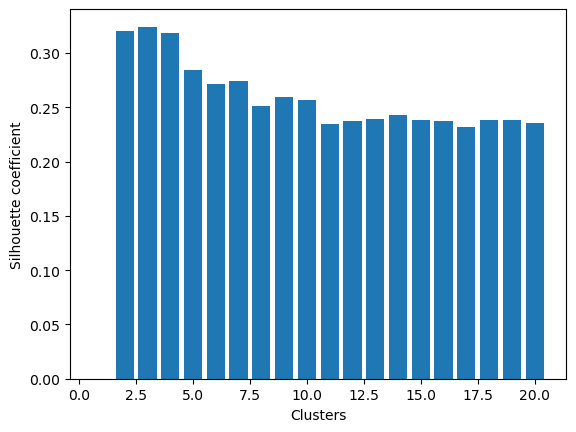

In [39]:
silhouettes = np.zeros(20)

for k in range(2, 21):
    kmeans = KMeans(k, n_init='auto')
    labels = kmeans.fit_predict(X_lda)
    silhouettes[k-1] = silhouette_score(X_lda, labels)
plt.bar(np.arange(1,21), silhouettes)
plt.xlabel('Clusters')
plt.ylabel('Silhouette coefficient')

In [41]:
min(silhouettes[1:])

0.2323056346419688

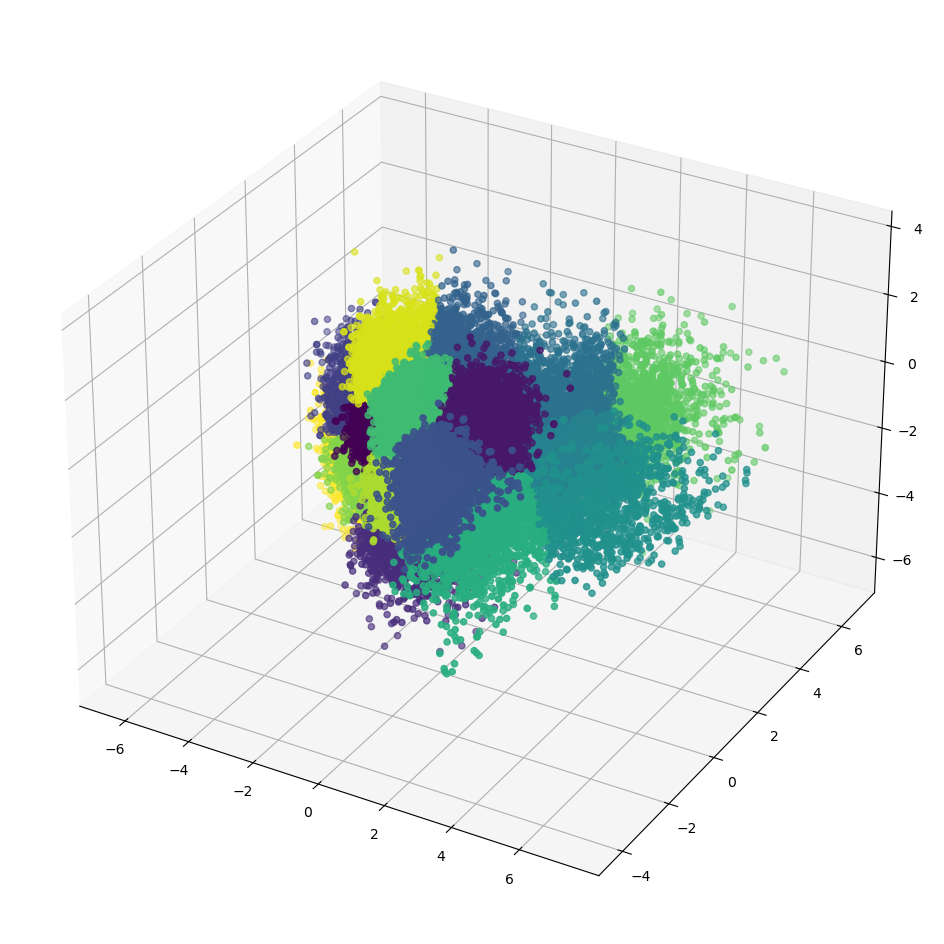

In [51]:
kmeans = KMeans(17, n_init='auto')
labels = kmeans.fit_predict(X_lda)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_lda[:,0], X_lda[:,1], X_lda[:,2],c=kmeans.labels_.astype(float))
plt.show()

In [52]:
kmeans.inertia_

50813.33856784334

# Classification

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, imputed_data[:,17], test_size=0.1, stratify=y)

In [75]:
model = RandomForestClassifier(n_estimators=100, max_samples=0.1, max_features=0.5,bootstrap=True, criterion='gini')
model.fit(X_train,y_train)

RandomForestClassifier(max_features=0.5, max_samples=0.1)

In [93]:
#code adapted from sklearn's Multiclass Receiver Operating Characteristic page

In [87]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(5001, 10)

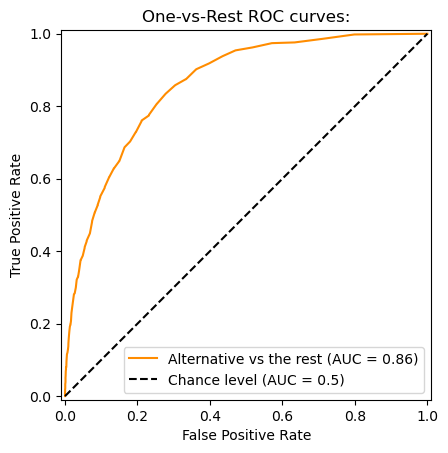

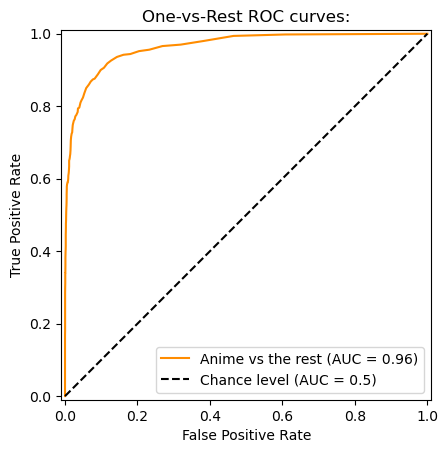

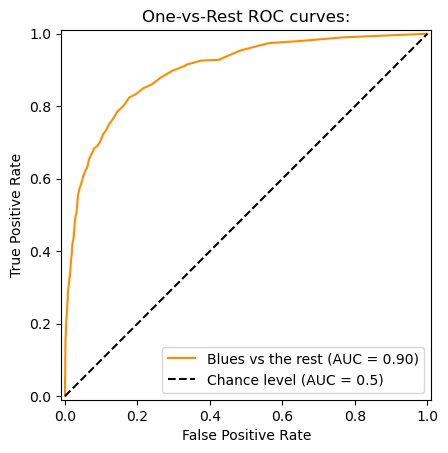

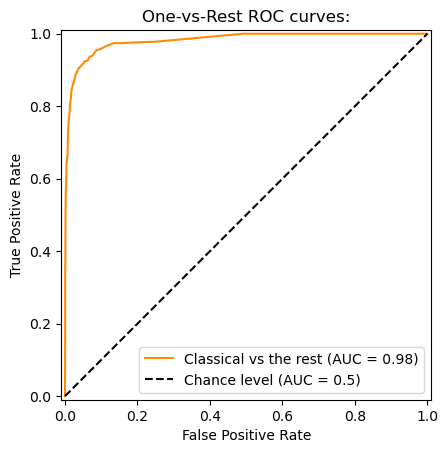

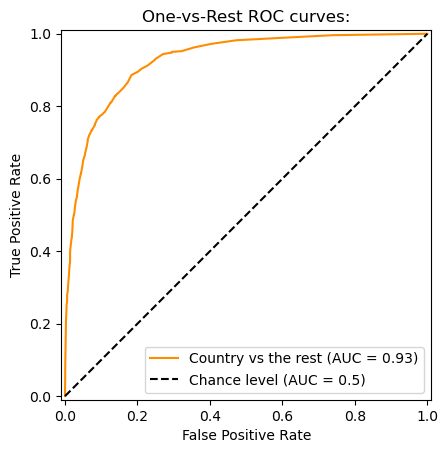

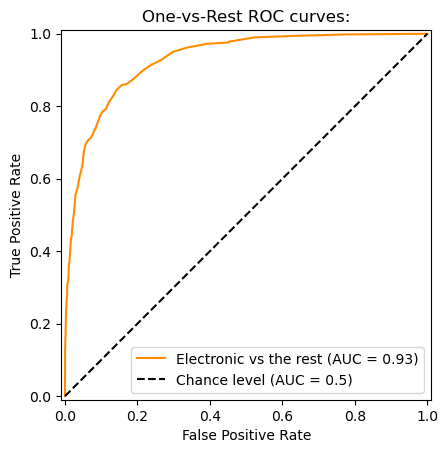

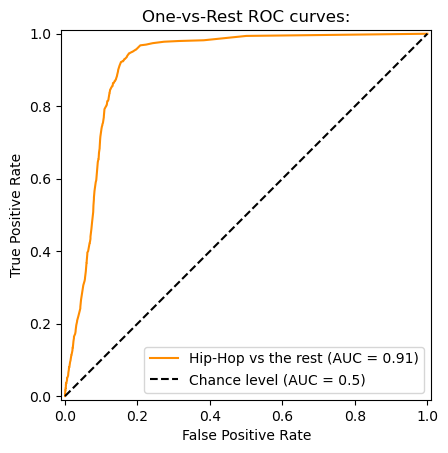

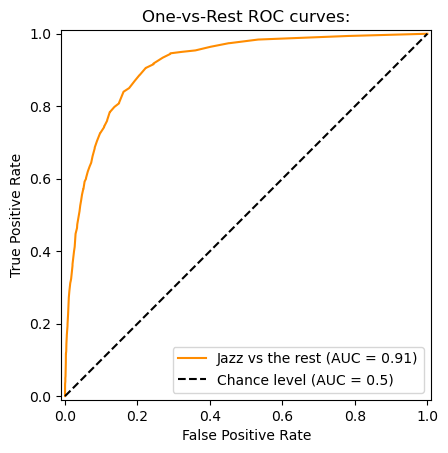

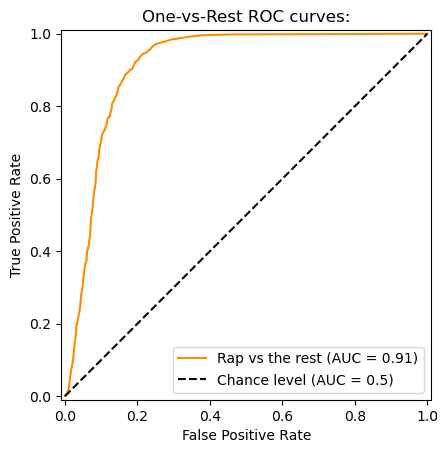

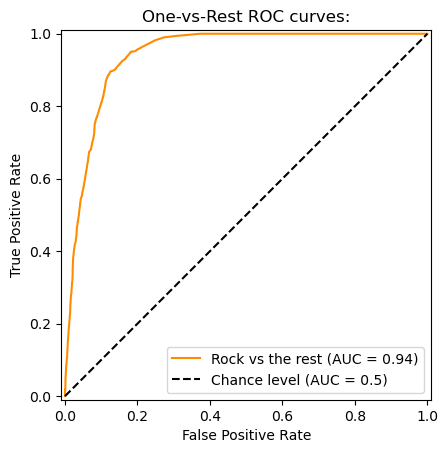

In [92]:
for i in ['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']:
    class_of_interest = i
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    y_score = model.predict_proba(X_test)
    
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="One-vs-Rest ROC curves:",
    )